In [1]:
import velodyne_decoder as vd
from datetime import datetime
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io
import numpy as np
import cv2
import matplotlib.patches as patches
from PIL import Image
from sklearn.cluster import DBSCAN
import time

In [2]:
# Functions

# Rotating the point clouds to be consistent with the video

def rotation_matrix(theta1, theta2, theta3, order='xyz'):
    c1 = np.cos(theta1 * np.pi / 180)
    s1 = np.sin(theta1 * np.pi / 180)
    c2 = np.cos(theta2 * np.pi / 180)
    s2 = np.sin(theta2 * np.pi / 180)
    c3 = np.cos(theta3 * np.pi / 180)
    s3 = np.sin(theta3 * np.pi / 180)
    matrix = np.array([[c2 * c3, -c2 * s3, s2],
                       [c1 * s3 + c3 * s1 * s2, c1 * c3 - s1 * s2 * s3, -c2 * s1],
                       [s1 * s3 - c1 * c3 * s2, c3 * s1 + c1 * s2 * s3, c1 * c2]])
    return matrix

# Converting to spherical co-ordinates 

# def cart2sph(x,y,z):
#     XsqPlusYsq = x**2 + y**2
#     r = math.sqrt(XsqPlusYsq + z**2)               # r
#     elev = math.atan2(z,math.sqrt(XsqPlusYsq))     # theta
#     az = math.atan2(y,x)                           # phi
#     return r, elev, az

def cart2sphA(xyz):
    ptsnew = np.zeros(xyz.shape)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)
#     ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    ptsnew[:,1] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

# def cart2sphA(pts):
#     return np.array([cart2sph(x,y,z) for x,y,z in pts])

# Cropping point cloud data.

def cropPtCloud(ptCloud):
    
    xLim = [-150, 150]
    yLim = [-150, 150]
    zLim = [-10, 10]
        
    insideX = np.logical_and(ptCloud[:,0] < xLim[1], ptCloud[:,0] > xLim[0])
    insideY = np.logical_and(ptCloud[:,1] < yLim[1], ptCloud[:,1] > yLim[0])
    insideZ = np.logical_and(ptCloud[:,2] < zLim[1], ptCloud[:,2] > zLim[0])
    
    validIndices = np.logical_and(np.logical_and(insideX, insideY), insideZ);
            
    return ptCloud[validIndices,:]

In [9]:
%%cython -a

cdef extern from "math.h":
    long double sqrt(long double xx)
    long double atan2(long double a, double b)

import numpy as np
cimport numpy as np
cimport cython

ctypedef np.float64_t DTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
def appendSpherical(np.ndarray[DTYPE_t,ndim=2] xyz):
    cdef np.ndarray[DTYPE_t,ndim=2] pts = np.empty((xyz.shape[0],6))
    cdef long double XsqPlusYsq
    for i in xrange(xyz.shape[0]):
        pts[i,0] = xyz[i,0]
        pts[i,1] = xyz[i,1]
        pts[i,2] = xyz[i,2]
        XsqPlusYsq = xyz[i,0]**2 + xyz[i,1]**2
        pts[i,3] = sqrt(XsqPlusYsq + xyz[i,2]**2)
        pts[i,4] = atan2(xyz[i,2],sqrt(XsqPlusYsq))
        pts[i,5] = atan2(xyz[i,1],xyz[i,0])
    return pts[:,3:]

In [3]:
# Reading the Point Cloud Data

config = vd.Config(model='VLP-32C', rpm=600)
pcap_file = '../LiDAR_data.pcap'
stamps = []
cloud_arrays = []

# Reading the pcap file framewise
for stamp, pts in tqdm(vd.read_pcap(pcap_file, config)):
    points = np.zeros_like(pts)
    points[:,0] = -1*pts[:,1]
    points[:,1] = pts[:,0]
    points[:,2] = pts[:,2]
    cloud_arrays.append(points)
    stamps.append(stamp)
    
# # Converting 600 frames of Point Cloud data to spherical
# for i in tqdm(range(600)):
#     cloud_sph_arr.append(cart2sphA(cloud_arrays[i][:,0:3]))

10627it [01:00, 176.40it/s]


In [24]:
# Load beams_elevation and range_thrld_matrix

range_thrld_matrix = scipy.io.loadmat('range_thrld_matrix.mat')
range_thrld_matrix = range_thrld_matrix['range_thrld_matrix']
beams_elevation = scipy.io.loadmat('beams_elevation_vlp32c.mat')
beams_elevation = beams_elevation['beams_elevation_vlp32c']

total_grid = 1800;
azimuth_unit = 360/total_grid;

filtered_point_cloud = []

for i in tqdm(range(600)):
    
    # Cropping the point cloud data and obtaining .
    cloud_array = cropPtCloud(cloud_arrays[i]);
    
    # Convert Cartesian to Spherical.
    cloud_sph_arr = cart2sphA(cloud_array[:,0:3])
    
    # Converting Azimuth from radians to degrees [0, 360]
    degree = cloud_sph_arr[:,2]
    degree = degree*180/3.14; # rad to deg
    degree[degree<0] = degree[degree<0] + 360
    
    # Assigning grids based on azimuth angle
    grids_idx = (np.floor(degree/azimuth_unit) + 1)%total_grid
    grids_idx[grids_idx == 0] = total_grid - 1  # deal with 1799 + 1 grid
    grids_idx[grids_idx == None] = 0 # LiDAR point NaN is set as 0
    grids_idx = grids_idx.astype(int)

    back_idxes = np.zeros(len(cloud_sph_arr))
    back_idxes[grids_idx == 0] = 1

    elevation_matrix = abs(np.zeros((len(beams_elevation),len(cloud_sph_arr))) + cloud_sph_arr[:,1] - beams_elevation)
    channel_num = np.argmin(elevation_matrix, axis = 0)

    mask = cloud_sph_arr[:,0] >=  range_thrld_matrix[channel_num, grids_idx]
    back_idxes[mask] = 1

    filtered_point_cloud.append(cloud_array[back_idxes == 0, 0:3])
    
#     # Point cloud filtering process
#     for pnt in (range(len(cloud_sph_arr))):
        
#         r = cloud_sph_arr[pnt,0]
#         elevation = cloud_sph_arr[pnt,1]
#         grid_idx = grids_idx[pnt]

#         if grid_idx == 0:
#             back_idxes[pnt] = 1
#             continue

#         channel_num = np.argmin(abs(beams_elevation - elevation))

#         if (r >= range_thrld_matrix[channel_num, grid_idx]):
#             back_idxes[pnt] = 1
            
#     filtered_point_cloud.append(cloud_array[back_idxes == 0, 0:3])

100%|██████████| 600/600 [00:06<00:00, 89.47it/s]


In [25]:
# Rotating the point clouds to be consistent with the video
filtered_point_cloud_1 = []
for i in tqdm(range(len(filtered_point_cloud))):
    tmp = rotation_matrix(0, 0, -43).dot(filtered_point_cloud[i][:,0:3].T).T
    tmp = rotation_matrix(25, -5, 0).dot(tmp.T).T
    filtered_point_cloud_1.append(rotation_matrix(0, 0, 0).dot(tmp.T).T)

100%|██████████| 600/600 [00:00<00:00, 3628.63it/s]


In [26]:
# Applying DBSCAN

clustered_point_cloud = []

for i in tqdm(range(len(filtered_point_cloud))):
    X = filtered_point_cloud_1[i][:,0:2]
    db = DBSCAN(eps=1, min_samples=17).fit(X)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)


    # Storing a rectangle for each cluster for later plotting on image
    rectangle_list = []
        
    for j in range(n_clusters_):
        class_member_mask = labels == j
        xy = X[class_member_mask, :]
        rectangle = [(int(125 + 20.5*np.min(xy[:, 0])), int(735 - 20*np.max(xy[:, 1]))), (int(125 + 20.5*np.max(xy[:, 0])), int(735 - 20*np.min(xy[:, 1])))]
        rectangle_list.append(rectangle)
    clustered_point_cloud.append(rectangle_list)
    
# print(rectangle_list)


100%|██████████| 600/600 [00:22<00:00, 27.15it/s]


100%|██████████| 600/600 [00:10<00:00, 54.73it/s]


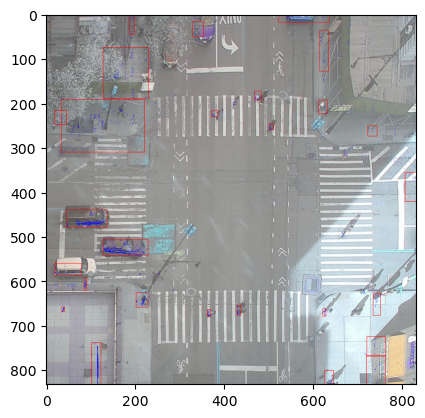

In [28]:
# writing on the video

cap = cv2.VideoCapture('../Videos/output1640b_transformed.mp4')
out = cv2.VideoWriter('../Videos/synchronization_filtered_demo.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (832, 832))

counter = 0

for i in range(43):
    ret, frame = cap.read()
    
time_stamp = stamps[0]
idx = 0
    
for j in tqdm(range(600)):
    ret, frame = cap.read()
    
    idx += np.argmin([abs(stamps[idx] -  time_stamp) , abs(stamps[idx + 1] -  time_stamp)])
    
    center = [None] * filtered_point_cloud_1[idx].shape[0]
    
    for i in range(filtered_point_cloud_1[idx].shape[0]):
        center[i] = (int(125 + 20.5*filtered_point_cloud_1[idx][i, 0]), int(735 - 20*filtered_point_cloud_1[idx][i, 1]))
        # 130 and 734 here are for translating the coordinate, 20 here is for scaling the resolution of the data to match the video resolution

    for i in range(len(center)):
        frame = cv2.circle(frame, center[i], radius=0, color=(0, 0, 255), thickness=-1) # circle function is for ploting the point cloud data on the picture frame

    for i in range(len(clustered_point_cloud[idx])):
        frame = cv2.rectangle(frame, pt1 = clustered_point_cloud[idx][i][0], pt2 = clustered_point_cloud[idx][i][1], color=(255,0,0), thickness=1)
        
    out.write(frame)
    
    time_stamp += 1/15
        
out.release()

plt.imshow(frame)


**Rough Work and Testing below this part:**

100%|██████████| 600/600 [00:10<00:00, 55.19it/s]


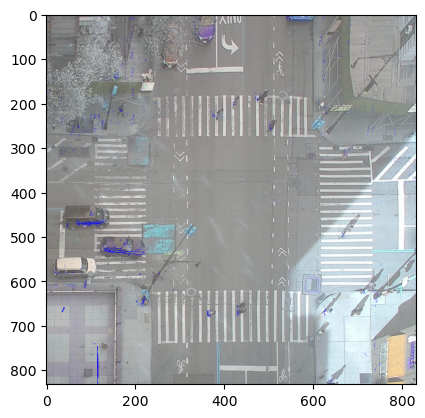

In [158]:
# writing on the video

cap = cv2.VideoCapture('output1640b_transformed.mp4')
out = cv2.VideoWriter('synchronization_filtered_demo.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (832, 832))

counter = 0

for i in range(43):
    ret, frame = cap.read()
    
time_stamp = stamps[0]
idx = 0
    
for j in tqdm(range(600)):
    ret, frame = cap.read()
    
    idx += np.argmin([abs(stamps[idx] -  time_stamp) , abs(stamps[idx + 1] -  time_stamp)])
    
    center = [None] * filtered_point_cloud_1[idx].shape[0]
    
    for i in range(filtered_point_cloud_1[idx].shape[0]):
        center[i] = (int(125 + 20.5*filtered_point_cloud_1[idx][i, 0]), int(735 - 20*filtered_point_cloud_1[idx][i, 1]))        # 130 and 734 here are for translating the coordinate, 20 here is for scaling the resolution of the data to match the video resolution

    for i in range(len(center)):
        synchronization_image = cv2.circle(frame, center[i], radius=0, color=(0, 0, 255), thickness=-1) # circle function is for ploting the point cloud data on the picture frame

    out.write(synchronization_image)
    
    time_stamp += 1/15
            
out.release()
plt.imshow(synchronization_image)


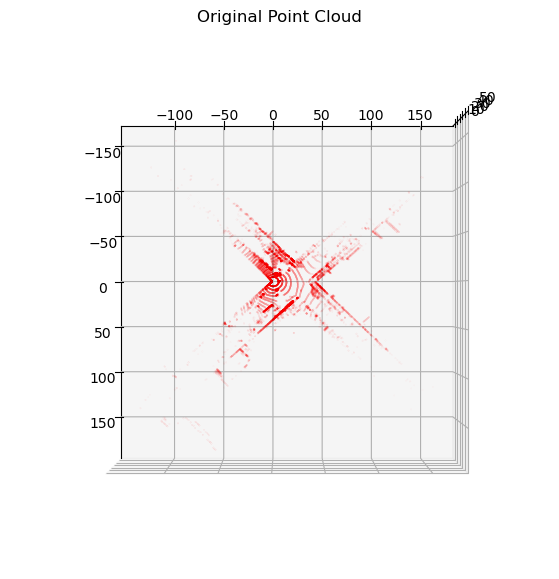

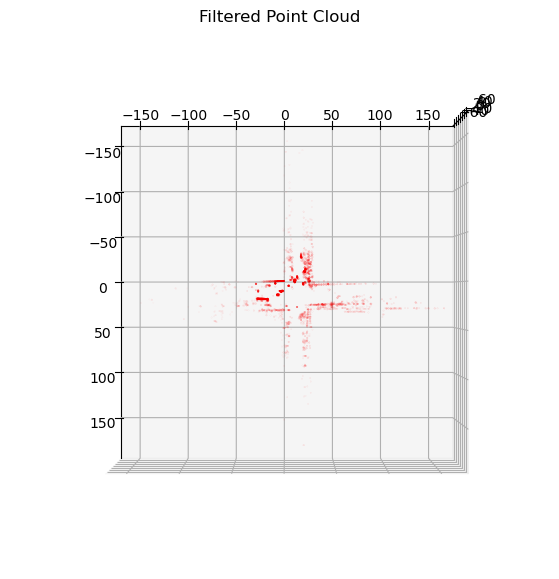

In [133]:
import numpy as np
import matplotlib.pyplot as plt

x = cloud_arrays[1][:,0]
y = cloud_arrays[1][:,1]
z = cloud_arrays[1][:,2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(projection='3d')

# Creating plot
ax.scatter( x, y, z, s = 0.001, color = "red")
ax.view_init(azim=0, elev=90)
plt.title("Original Point Cloud")
 
# show plot
plt.show()

x = filtered_point_cloud_1[1][:,0]
y = filtered_point_cloud_1[1][:,1]
z = filtered_point_cloud_1[1][:,2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(projection = '3d')

# Creating plot
ax.scatter(x, y, z, s = 0.001, color = "red")
ax.view_init(azim=0, elev=90)
plt.title("Filtered Point Cloud")

    
# show plot
plt.show()


In [154]:
filtered_point_cloud_1 = []

for i in tqdm(range(len(filtered_point_cloud))):
    tmp = rotation_matrix(0, 0, -43).dot(filtered_point_cloud[i][:,0:3].T).T
    tmp = rotation_matrix(25, -5, 0).dot(tmp.T).T
    filtered_point_cloud_1.append(rotation_matrix(0, 0, 0).dot(tmp.T).T)

100%|██████████| 600/600 [00:00<00:00, 3975.54it/s]


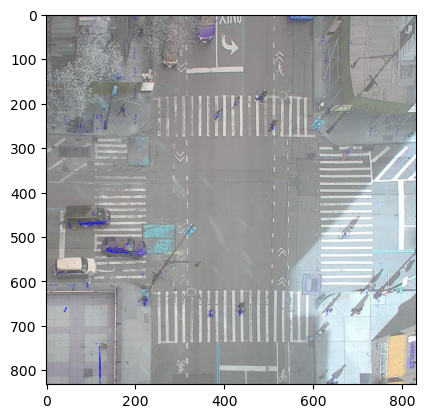

In [156]:
# Extracting frame

cap = cv2.VideoCapture('output1640b_transformed.mp4')
out = cv2.VideoWriter('synchronization_filtered_demo.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (832, 832))

counter = 0

for i in range(644):
    ret, frame = cap.read()  

center = [None] * filtered_point_cloud_1[idx].shape[0]

idx = 399
    
for i in range(filtered_point_cloud_1[idx].shape[0]):
    center[i] = (int(130 + 20.5*filtered_point_cloud_1[idx][i, 0]), int(735 - 20*filtered_point_cloud_1[idx][i, 1]))
    # 130 and 734 here are for translating the coordinate, 20 here is for scaling the resolution of the data to match the video resolution

for i in range(len(center)):
    synchronization_image = cv2.circle(frame, center[i], radius=0, color=(0, 0, 255), thickness=-1) # circle function is for ploting the point cloud data on the picture frame

plt.imshow(synchronization_image)

In [111]:
from sklearn.cluster import DBSCAN
import time
X = filtered_point_cloud[399][:,0:2]
print(X.shape)
start_time  = time.time()
db = DBSCAN(eps=0.6, min_samples=17).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
end_time = time.time()
print(end_time-start_time)

(7461, 2)
Estimated number of clusters: 58
Estimated number of noise points: 2953
0.05856776237487793


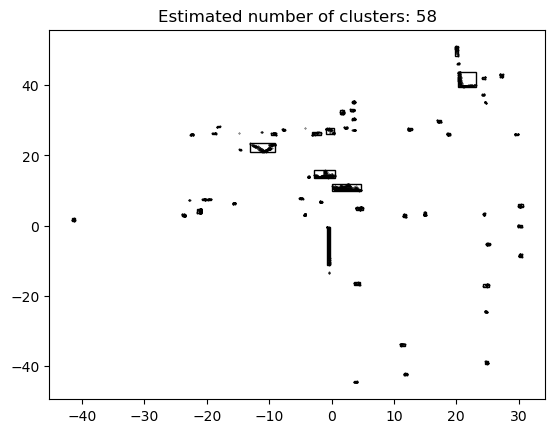

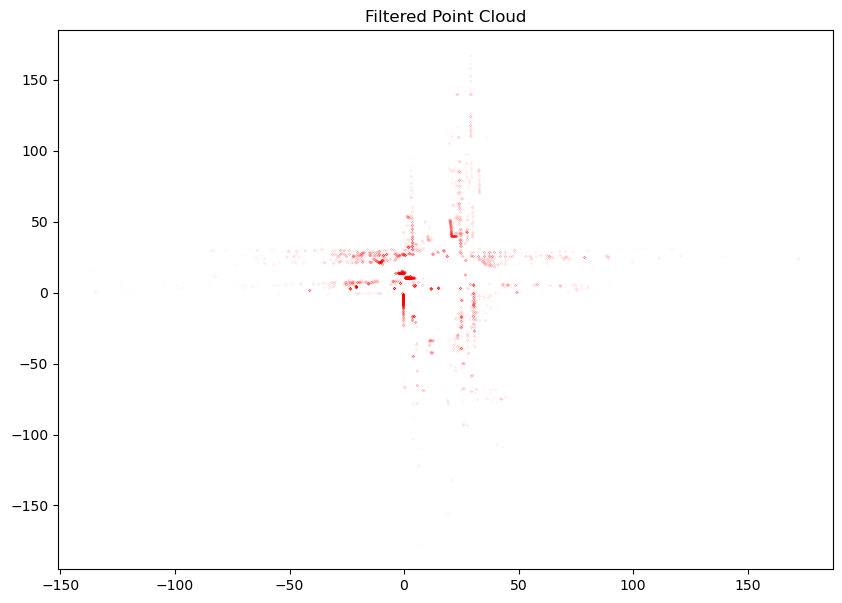

In [112]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    
    col = [0, 0, 0, 1]
    
    if k == -1:
        # Black used for noise.
        col = [0,0,0,0]
        continue

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
        
    if xy.shape[0]>0:
        plt.scatter(
            xy[:, 0],
            xy[:, 1],
            color = tuple(col),
    #         markeredgecolor="k",
            s = 0.1,
        )

    
        rect = patches.Rectangle((np.min(xy[:, 0]), np.min(xy[:, 1])), np.max(xy[:, 0])-np.min(xy[:, 0]), np.max(xy[:, 1])-np.min(xy[:, 1]), linewidth=1, edgecolor=tuple(col), facecolor='none')
        plt.gca().add_patch(rect)

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()
plt.show()

x = filtered_point_cloud[399][:,0]
y = filtered_point_cloud[399][:,1]
z = filtered_point_cloud[399][:,2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
# ax = fig.add_subplot(projection = '3d')

# Creating plot
plt.scatter(x, y, s = 0.001, color = "red")
plt.title("Filtered Point Cloud")
 
# show plot
plt.show()

In [21]:
# Load beams_elevation and range_thrld_matrix

range_thrld_matrix = scipy.io.loadmat('range_thrld_matrix.mat')
range_thrld_matrix = range_thrld_matrix['range_thrld_matrix']
beams_elevation = scipy.io.loadmat('beams_elevation_vlp32c.mat')
beams_elevation = beams_elevation['beams_elevation_vlp32c']

total_grid = 1800;
azimuth_unit = 360/total_grid;

filtered_point_cloud = []

# for i in tqdm(range(600)):
    
# Cropping the point cloud data and obtaining .
cloud_array = cropPtCloud(cloud_arrays[0]);

# Convert Cartesian to Spherical.
cloud_sph_arr = cart2sphA(cloud_array[:,0:3])

# Converting Azimuth from radians to degrees [0, 360]
degree = cloud_sph_arr[:,2]
degree = degree*180/3.14; # rad to deg
degree[degree<0] = degree[degree<0] + 360

# Assigning grids based on azimuth angle
grids_idx = (np.floor(degree/azimuth_unit) + 1)%total_grid
grids_idx[grids_idx == 0] = total_grid - 1  # deal with 1799 + 1 grid
grids_idx[grids_idx == None] = 0 # LiDAR point NaN is set as 0
grids_idx = grids_idx.astype(int)

for pnt in (range(len(cloud_sph_arr))):

    r = cloud_sph_arr[pnt,0]
    elevation = cloud_sph_arr[pnt,1]
    grid_idx = grids_idx[pnt]

    if grid_idx == 0:
        back_idxes[pnt] = 1
        continue

    channel_num = np.argmin(abs(beams_elevation - elevation))

    if (r >= range_thrld_matrix[channel_num, grid_idx]):
        back_idxes[pnt] = 1

filtered_point_cloud.append(cloud_array[back_idxes == 0, 0:3])

In [22]:
back_idxes_test = np.zeros(len(cloud_sph_arr))    
back_idxes_test[grids_idx == 0] = 1

elevation_matrix = abs(np.zeros((len(beams_elevation),len(cloud_sph_arr))) + cloud_sph_arr[:,1] - beams_elevation)
channel_num = np.argmin(elevation_matrix, axis = 0)

mask = cloud_sph_arr[:,0] >=  range_thrld_matrix[channel_num, grids_idx]
back_idxes_test[mask] = 1

# # Point cloud filtering process
# for pnt in (range(len(cloud_sph_arr))):

#     r = cloud_sph_arr[pnt,0]
#     elevation = cloud_sph_arr[pnt,1]
#     grid_idx = grids_idx[pnt]

#     if grid_idx == 0:
#         back_idxes[pnt] = 1
#         continue

#     channel_num = np.argmin(abs(beams_elevation - elevation))

#     if (r >= range_thrld_matrix[channel_num, grid_idx]):
#         back_idxes[pnt] = 1

# filtered_point_cloud.append(cloud_array[back_idxes == 0, 0:3])

0.0


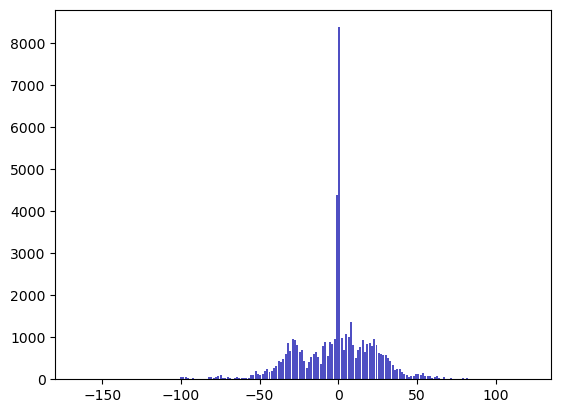

399


In [34]:
n, bins, patches = plt.hist(x=-1*cloud_arrays[0][:,0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.show()
print(idx)

In [7]:
print(np.mean(cloud_arrays[0][:,0]), np.mean(cloud_arrays[0][:,1]), np.mean(cloud_arrays[0][:,2]))

8.5318 -1.8553587 0.0097642215


In [27]:
!conda install -c anaconda scikit-learn 

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.3.1



## Package Plan ##

  environment location: /Users/rajatyagi/anaconda3/envs/myenv

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.4.26  |       hecd8cb5_0         132 KB  anaconda
    certifi-2022.6.15          |  py310hecd8cb5_0         157 KB  anaconda
    joblib-1.1.0               |     pyhd3eb1b0_0         211 KB  anaconda
    scikit-learn-1.0.2         |  py310hc081a56_0         7.4 MB  anaconda
    threadpoolctl-2.2.0        |     pyh0d69192_0          16 KB  anaconda

In [3]:
%load_ext cython